In [1]:
import getpass
import os
import torch
import numpy as np
from PIL import Image
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import torch.nn.functional as F
#from skimage import transform
import sys
from sklearn.metrics import roc_curve, auc
import copy
import torchvision.models as models
import re
import xml.etree.ElementTree as ET
import cv2
#from display import read_image, draw_boxes, draw_grid, draw_text
#import display

In [2]:
# with this function you set the value of the environment variable CUDA_VISIBLE_DEVICES
# to set which GPU to use
# it also reserves this amount of memory for your exclusive use. This might be important for 
# not having other people using the resources you need in shared systems
# the homework was tested in a GPU with 4GB of memory, and running this function will require at least
# as much
# if you want to test in a GPU with less memory, you can call this function
# with the argument minimum_memory_mb specifying how much memory from the GPU you want to reserve
def define_gpu_to_use(minimum_memory_mb = 3800):
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        if free_memory>minimum_memory_mb-500:
            gpu_to_use = i
            break
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' +str(minimum_memory_mb) + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-500)).cuda()
        x = torch.rand((1,1)).cuda()
        del x
define_gpu_to_use()

Chosen GPU: 0


In [3]:
def read_image(image, size):
    img = cv2.imread(image, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (size, size))
    return img

In [4]:
def draw_boxes(image, boxes_list):
    for boxes in boxes_list:
        cv2.rectangle(image, (int(boxes[0]-boxes[2]/2),int(boxes[1]-boxes[3]/2)),(int(boxes[0]+boxes[2]/2),int(boxes[1]+boxes[3]/2)),(0,0,255),2)
    return image

In [5]:
def draw_grid(img, pixel_step):
    x = pixel_step
    y = pixel_step

    while x < img.shape[1]:
        cv2.line(img, (x, 0), (x, img.shape[0]), color=(255, 255, 255))
        x += pixel_step

    while y < img.shape[0]:
        cv2.line(img, (0, y), (img.shape[1], y), color=(255, 255, 255))
        y += pixel_step

    return img

In [6]:
def draw_text(img, text_list, location):
    for text,loc in zip(text_list, location):
        cv2.putText(img, text, (int(loc[0]), int(loc[1])), cv2.FONT_HERSHEY_COMPLEX,0.5, (255, 0, 0), 1)
    return img

In [7]:
def img_normalize(image):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    img = normalize(torch.from_numpy(image))
    return img.numpy()

def preprocess(img, min_size=600, max_size=1000):
    C,H,W = img.shape
    scale1 = min_size/min(H,W)
    scale2 = max_size/max(H,W)
    scale = min(scale1, scale2)
    img = img/255
    img = transform.resize(img, (C,H*scale, W*scale), mode='reflect', anti_aliasing=False)
    normalize = img_normalize
    return normalize(img)

In [8]:
class CropBiggestCenteredInscribedSquare(object):
    def __init__(self):
        pass

    def __call__(self, tensor):
        longer_side = min(tensor.size)
        horizontal_padding = (longer_side - tensor.size[0]) / 2
        vertical_padding = (longer_side - tensor.size[1]) / 2
        return tensor.crop(
            (
                -horizontal_padding,
                -vertical_padding,
                tensor.size[0] + horizontal_padding,
                tensor.size[1] + vertical_padding
            )
        )

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [9]:
def split_data(image_name_list, split_type):
    np.random.seed(31)
    np.random.shuffle(image_name_list)
    np.random.seed()
    if split_type == 'train':
        image_name_list = image_name_list[:int(len(image_name_list)*0.6)]
    elif split_type == 'validate':
        image_name_list = image_name_list[int(len(image_name_list)*0.6):int(len(image_name_list)*0.8)]
    elif split_type== 'test':
        image_name_list = image_name_list[int(len(image_name_list)*0.8):]
    return image_name_list

In [10]:
class plant_leaf_disease_dataset(Dataset):
    def __init__(self, data_dir_bounding_box,data_dir_images,split="train"):
        self.data_dir_bounding_box = data_dir_bounding_box
        self.data_dir_images = data_dir_images
        self.grid_size=20
        self.label_names = ['AppleScab','CedarAppleRust','CherryPowderyMildew','FrogEyeSpot','CherrySourPowderyMildew','CornMaizeCercosporaGrayLeafSpot','CornMaizeCommonRust','CornMaizeHealthy','CornMaizeNorthernLeafBlight','GrapeBlackRot','GrapeEscaBlackMeasles','GrapeLeafBlightIsariopsis','OrangeHaungLongbingCitrus','PeachBacterialSpot','PepperBellBacterialSpot','PotatoEarlyBlight','PotatoLateBlight','SquashPowderyMildew','StrawberryLeafScorch','TomatoBacterialSpot','TomatoEarlyBlight','TomatoLateBlight','TomatoLeafMold','TomatoSeptoriaLeafSpot','TomatoSpiderMitesTwoSpotted','TomatoTargetSpot','TomatoMosaicVirus','TomatoYellowLeafCurlVirus']
        columns=['image_name','label','bounding_boxes', 'new_bounding_boxes','xmin','ymin','xmax','ymax']
        combined_dataset = []
        for subdir, dirs, files in os.walk(self.data_dir_bounding_box):
            for file in files:
                #print (file)
                bounding_box, label_name, image_name=self.get_example(file) #ordering xmin, ymin, xmax, ymax
                new_bounding_box = self.convert_to_center(bounding_box)
                #print (bounding_box)
                record_data = [image_name, label_name, bounding_box, new_bounding_box, bounding_box[:,0], bounding_box[:,1],bounding_box[:,2], bounding_box[:,3]]
                combined_dataset.append(record_data)
        self.dataset_df = pd.DataFrame(combined_dataset, columns = columns)
        self.dataset_df['grid_boxes'] = self.dataset_df['bounding_boxes'].apply(lambda x:self.grid_formation(x))
        
        image_name_list = pd.unique(self.dataset_df['image_name'])
        splitted_data = split_data(image_name_list,split)
        image_name_list = pd.DataFrame(splitted_data,columns=['image_name'])
        subset_data = pd.merge(image_name_list,self.dataset_df)
        #print (len(subset_data))
        self.dataset_df = subset_data
        self.images = self.dataset_df['image_name'].values
        self.targets = self.dataset_df['label'].values
        self.bounding_boxes = self.dataset_df['bounding_boxes'].values
        self.grid_boxes = self.dataset_df['grid_boxes'].values
        self.new_bounding_boxes = self.dataset_df['new_bounding_boxes'].values
        print (len(self.dataset_df))
        #print (self.dataset_df.head())    
        #print (self.grid_boxes[0].shape)
    
    def grid_formation(self,b_boxes):
        img_original_size=256
        grid_mat = torch.zeros([1,1,img_original_size, img_original_size],dtype=torch.float)
        #print (b_boxes.shape)
        for b_box in b_boxes:
            #print (b_box[1,:].item())
            y1= int(b_box[1,:].item())
            y2=int(b_box[3,:].item())
            x1=int(b_box[0,:].item())
            x2=int(b_box[2,:].item())
            
            grid_mat[:,:,y1:y2,x1:x2] = 1.0
        first_resize_size = (img_original_size//self.grid_size)*self.grid_size
        grid_mat = torch.nn.functional.interpolate(grid_mat, size = (first_resize_size, first_resize_size), mode = 'bilinear', align_corners = False)
        grid_mat = torch.nn.AvgPool2d(kernel_size = img_original_size//self.grid_size)(grid_mat)
        grid_mat = ((grid_mat[0,:,:,:][:]>0.5)*1.0).float()
        return grid_mat
    
    def convert_to_center(self, b_boxes):
        new_box=[]
        for b_box in b_boxes:
            cx = b_box[0]+b_box[2]/2
            cy = b_box[1]+b_box[3]/2
            new_box.append([cx,cy,b_box[2], b_box[3]])
        return new_box
        
    def get_example(self,file_name):
        #print ()
        annotate = ET.parse(os.path.join(self.data_dir_bounding_box,re.findall("[a-zA-Z]+",file_name)[0],file_name))
        image_name = annotate.find('filename').text
        #bounding_box = list()
        #label=list()
        for obj in annotate.findall('object'):
            bounding_box_values = obj.find('bndbox')
            bounding_box = [int(bounding_box_values.find(tag).text) for tag in ('xmin','ymin','xmax','ymax')]
            label_name=obj.find('name').text.strip()
            bounding_box = np.vstack(bounding_box)
            bounding_box = torch.from_numpy(bounding_box[None,:,:]).float()
            #print (bounding_box)
            #label.append(label_name)
        #print (bounding_box)
        #print (label_name)
        #bounding_box = np.stack(bounding_box).astype(np.float32)
        #label = np.stack(label).astype(np.int32) #need to change this
        return bounding_box,label_name, image_name
    
    def __getitem__(self, index):
        set_of_transforms = transforms.Compose(
        [CropBiggestCenteredInscribedSquare(),
         transforms.Resize(256),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
        image_val = set_of_transforms(Image.open(self.data_dir_images + '/' + self.targets[index]+'/'+ self.images[index]).convert('RGB'))
        return self.images[index],image_val, self.label_names.index(self.targets[index]),self.new_bounding_boxes[index] #, self.grid_boxes[index]
    
    def __len__(self):
        return len(self.images)        

In [12]:
path_to_bounding_box = "../bounding_box/"
path_to_image_folder = "../leafDataForBoudingBox/"
label_names_dataset = ['AppleScab','CedarAppleRust','CherryPowderyMildew','FrogEyeSpot','CherrySourPowderyMildew','CornMaizeCercosporaGrayLeafSpot','CornMaizeCommonRust','CornMaizeHealthy','CornMaizeNorthernLeafBlight','GrapeBlackRot','GrapeEscaBlackMeasles','GrapeLeafBlightIsariopsis','OrangeHaungLongbingCitrus','PeachBacterialSpot','PepperBellBacterialSpot','PotatoEarlyBlight','PotatoLateBlight','SquashPowderyMildew','StrawberryLeafScorch','TomatoBacterialSpot','TomatoEarlyBlight','TomatoLateBlight','TomatoLeafMold','TomatoSeptoriaLeafSpot','TomatoSpiderMitesTwoSpotted','TomatoTargetSpot','TomatoMosaicVirus','TomatoYellowLeafCurlVirus']
train_dataset = plant_leaf_disease_dataset(path_to_bounding_box,path_to_image_folder)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle = True, batch_size = 28, num_workers = 3)
validate_dataset = plant_leaf_disease_dataset(path_to_bounding_box,path_to_image_folder,split="validate")
test_dataset = plant_leaf_disease_dataset(path_to_bounding_box,path_to_image_folder,split="test")
#torch..utils.data.DataLoader(dataset,)
validate_loader = torch.utils.data.DataLoader(validate_dataset, shuffle = True, batch_size = 28, num_workers = 3)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle = True, batch_size = 28, num_workers = 3)
print (len(test_dataset))

149
50
50
50


2
[[tensor([240.]), tensor([179.]), tensor([232.]), tensor([192.])]]


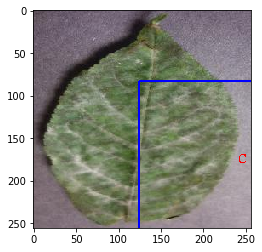

In [15]:
i = train_dataset.__getitem__(0)
img=i[0]
print (i[2])
img = read_image(path_to_image_folder+"/"+label_names_dataset[i[2]]+"/"+img, 256)
img = draw_boxes(img, i[3])
print (i[3])
img = draw_text(img, label_names_dataset[i[2]], i[3])
plt.imshow(img)
plt.show()


In [16]:
anchor_grid = [4,2,1]
anchor_zooms = [0.7,1.10,1.3]
anchor_ratios = [(1.0,1.0),(1.0,0.5),(0.5,1.0)]
anchor_scales = [(a*h,a*w) for a in anchor_zooms for (h,w) in anchor_ratios]
anchor_offsets = [1/(2*o) for o in anchor_grid]
num_boxes = len(anchor_scales)

In [17]:
anchor_x = [np.repeat(np.linspace(anchor_off,1-anchor_off, a_grid),a_grid) for (anchor_off,a_grid) in zip(anchor_offsets, anchor_grid)]
anchor_x = np.concatenate(anchor_x)
anchor_y = [np.tile(np.linspace(ao, 1-ao, ag), ag) for ao,ag in zip(anchor_offsets, anchor_grid)]
anchor_y = np.concatenate(anchor_y)
anchor_centers = np.repeat(np.stack([anchor_x, anchor_y], axis=1), num_boxes,axis=0)

In [18]:
anchor_sizes  = [np.array([[w/ag, h/ag] for _ in range(ag**2) for w, h in anchor_scales])
                 for ag in anchor_grid]
anchor_sizes = np.concatenate(anchor_sizes)

anchors = np.concatenate([anchor_centers, anchor_sizes], axis=1)
anchors = torch.from_numpy(anchors).float()
anchors = anchors.cuda()

In [19]:

def flatten_conv(x, num_boxes):
    samples, channels, _, _ = x.size()
    x = x.permute(0, 2, 3, 1).contiguous()
    return x.view(samples, -1, int(channels/num_boxes))

class StandardConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn = torch.nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = self.bn(x)
        return x        

class OutputConv(torch.nn.Module):
    def __init__(self, in_channels, num_boxes):
        super().__init__()
        self.num_boxes = num_boxes
        self.conv_1 = torch.nn.Conv2d(in_channels, (len(train_dataset)+1)*num_boxes, kernel_size=3, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels, 4*num_boxes, kernel_size=3, padding=1)

    def forward(self, x):
        # [class predictions, box coordinates]
        return [flatten_conv(self.conv_1(x), self.num_boxes), 
                flatten_conv(self.conv_2(x), self.num_boxes)]

class Model(torch.nn.Module):
    def __init__(self, num_boxes):
        super().__init__()

        pretrained_model = list(models.vgg16(pretrained='imagenet').children())[:-1]
        self.pretrained_model = torch.nn.Sequential(*pretrained_model)

        self.std_conv_1 = StandardConv(512, 256, stride=1)
        self.std_conv_2 = StandardConv(256, 256)
        self.std_conv_3 = StandardConv(256, 256)
        self.std_conv_4 = StandardConv(256, 256)

        self.out_conv_1 = OutputConv(256, num_boxes)
        self.out_conv_2 = OutputConv(256, num_boxes)
        self.out_conv_3 = OutputConv(256, num_boxes)

    def forward(self, x):
        x = self.pretrained_model(x)
        x = F.relu(x)
        x = self.std_conv_1(x)
        x = self.std_conv_2(x)
        output_class_1, output_bb_1 = self.out_conv_1(x)

        x = self.std_conv_3(x)
        output_class_2, output_bb_2 = self.out_conv_2(x)

        x = self.std_conv_4(x)
        output_class_3, output_bb_3 = self.out_conv_3(x)

        # Class, bounding box
        return [torch.cat([output_class_1, output_class_2, output_class_3], dim=1),
                torch.cat([output_bb_1, output_bb_2, output_bb_3], dim=1)
                ]

    def change_freezing(self, mode=False):
        for param in self.pretrained_model.parameters():
            param.requires_grad = mode

In [20]:
def find_overlap(bb_true_i, anchors, jaccard_overlap):
    jaccard_tensor = jaccard(anchors, bb_true_i)
    _, max_overlap = torch.max(jaccard_tensor, dim=0)
    
    overlap_list = []    
    for i in range(len(bb_true_i)):
        threshold_overlap = (jaccard_tensor[:, i] > jaccard_overlap).nonzero()

        if len(threshold_overlap) > 0:
            threshold_overlap = threshold_overlap[:, 0]
            overlap = torch.cat([max_overlap[i].view(1), threshold_overlap])
            overlap = torch.unique(overlap)     
        else:
            overlap = max_overlap[i].view(1)
        overlap_list.append(overlap)
    return overlap_list

In [21]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.25, gamma=2, device="cuda", eps=1e-10):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.device = device
        self.eps = eps

    def forward(self, input, target):
        p = torch.sigmoid(input)
        pt = p * target.float() + (1.0 - p) * (1 - target).float()
        alpha_t = (1.0 - self.alpha) * target.float() + self.alpha * (1 - target).float()
        loss = - 1.0 * torch.pow((1 - pt), self.gamma) * torch.log(pt + self.eps)
        return loss.sum()

In [22]:
class SSDLoss(torch.nn.Module):
    def __init__(self, loc_factor, anchors, jaccard_overlap, **kwargs):
        super().__init__()
        self.fl = FocalLoss(**kwargs)
        self.loc_factor = loc_factor
        self.jaccard_overlap = jaccard_overlap
        self.anchors = anchors

    @staticmethod
    def one_hot_encoding(labels, num_classes):
        return torch.eye(num_classes)[labels]

    @staticmethod
    def loc_transformation(x, anchors, overlap_indicies):
        # Doing location transformations according to SSD paper
        return torch.cat([(x[:, 0:1] - anchors[overlap_indicies, 0:1]) / anchors[overlap_indicies, 2:3],
                          (x[:, 1:2] - anchors[overlap_indicies, 1:2]) / anchors[overlap_indicies, 3:4],
                          torch.log((x[:, 2:3] / anchors[overlap_indicies, 2:3])),
                          torch.log((x[:, 3:4] / anchors[overlap_indicies, 3:4]))
                         ], dim=1)

    def forward(self, class_hat, bb_hat, class_true, bb_true):        
        loc_loss = 0.0
        class_loss = 0.0

        for i in range(len(class_true)):  # Batch level
            class_hat_i = class_hat[i, :, :]
            print (class_hat_i.shape)
            bb_true_i = bb_true[i]
            class_true_i = class_true[i]
            class_target = torch.zeros(class_hat_i.shape[0]).long().cuda()
            overlap_list = find_overlap(bb_true_i, self.anchors, self.jaccard_overlap) # changed - bb_true_i.squeeze(0)

            temp_loc_loss = 0.0
            for j in range(len(overlap_list)):  # BB level
                overlap = overlap_list[j]
                class_target[overlap] = class_true_i[0, j]

                input_ = bb_hat[i, overlap, :]
                target_ = SSDLoss.loc_transformation(bb_true_i[0, j, :].expand((len(overlap), 4)), self.anchors, overlap)

                temp_loc_loss += F.smooth_l1_loss(input=input_, target=target_, reduction="sum") / len(overlap)
            loc_loss += temp_loc_loss / class_true_i.shape[1]

            class_target = SSDLoss.one_hot_encoding(class_target, len(id_cat) + 1).float().cuda()
            class_loss += self.fl(class_hat_i, class_target) / class_true_i.shape[1]

        loc_loss = loc_loss / len(class_true)
        class_loss = class_loss / len(class_true)
        loss = class_loss + loc_loss * self.loc_factor

        return loss, loc_loss, class_loss

In [23]:
loss = SSDLoss(loc_factor=5.0, anchors=anchors, jaccard_overlap=0.4)

In [24]:
seed=42
print (num_boxes)
torch.manual_seed(seed)
model = Model(num_boxes=num_boxes).cuda()
model.change_freezing(False)

9


In [25]:
n_epochs = 40
lr = 1e-4
wd = 0.0005

In [26]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)

In [29]:
def jaccard(box_a: torch.Tensor, box_b: torch.Tensor) -> float:
    intersection = intersect(box_a, box_b)
    union = box_area(box_a).unsqueeze(1) + box_area(box_b).unsqueeze(0) - intersection
    return intersection / union
def intersect(box_a: torch.Tensor, box_b: torch.Tensor) -> float:
    # Coverting (cx, cy, w, h) to (x1, y1, x2, y2) since its easier to extract min/max coordinates
    temp_box_a, temp_box_b = center_2_hw(box_a), center_2_hw(box_b)

    max_xy = torch.min(temp_box_a[:, None, 2:], temp_box_b[None, :, 2:])
    min_xy = torch.max(temp_box_a[:, None, :2], temp_box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]
def center_2_hw(box: torch.Tensor) -> float:
    """
    Converting (cx, cy, w, h) to (x1, y1, x2, y2)
    """
    print (len(box))
    return torch.cat(
        [box[:, 0, None] - box[:, 2, None]/2,
         box[:, 1, None] - box[:, 3, None]/2,
         box[:, 0, None] + box[:, 2, None]/2,
         box[:, 1, None] + box[:, 3, None]/2
         ], dim=1)
#     print (len(box[:,0]))
#     print ("done")
#     return torch.cat(
#         [box[:, 0] - box[:, 2]/2,
#          box[:, 1] - box[:, 3]/2,
#          box[:, 0] + box[:, 2]/2,
#          box[:, 1] + box[:, 3]/2
#          ])



In [37]:
def ff(x1,x2,x3,x4):
    return [x1,x2,x3,x4]
torch.manual_seed(seed)
for epoch in range(0, n_epochs+1):
    model.train()
    train_loss = 0.0

    loc_loss = 0.0
    class_loss = 0.0
    #self.images[index],image_val, self.label_names.index(self.targets[index]),self.new_bounding_boxes[index]
    for (_,x, class_true,bb_true) in train_loader:
        model.zero_grad()
        
        x=x.cuda()
        #class_true=class_true.cuda()
        print (bb_true)
        #bb_true = list(map(ff, bb_true[0].numpy(),bb_true[1].numpy(), bb_true[2].numpy(), bb_true[3].numpy()))
        #bb_true = bb_true.cuda()
        #print (bb_true)
        #bb_true=torch.FloatTensor(bb_true).cuda()
        class_hat, bb_hat = model(x)
        #print (bb_hat.shape)
        batch_loss, batch_loc, batch_class = loss(class_hat, bb_hat, class_true, bb_true)
        batch_loss.backward()
        optimizer.step()

        class_loss += batch_class
        loc_loss += batch_loc
        train_loss += batch_loss

    train_loss = (train_loss/len(train_loader)).detach().cpu().numpy()
    loc_loss = (loc_loss/len(train_loader)).detach().cpu().numpy()
    class_loss = (class_loss/len(train_loader)).detach().cpu().numpy()

    if epoch % 5 == 0:
        print(f"----- epoch {epoch} -----")
        print("Train loss: {:.4f}".format(train_loss))
        print("Loc loss: {:.4f}".format(loc_loss))
        print("Class loss: {:.4f}".format(class_loss))

[[tensor([[143.0000],
        [270.0000],
        [176.5000],
        [172.5000],
        [286.5000],
        [ 89.0000],
        [252.0000],
        [ 59.5000],
        [240.0000],
        [104.5000],
        [193.5000],
        [ 90.5000],
        [260.5000],
        [130.0000],
        [291.5000],
        [274.0000],
        [173.0000],
        [216.0000],
        [103.5000],
        [181.0000],
        [188.5000],
        [183.5000],
        [139.0000],
        [259.0000],
        [244.0000],
        [169.0000],
        [194.5000],
        [182.5000]]), tensor([[219.0000],
        [138.5000],
        [115.5000],
        [158.0000],
        [218.0000],
        [274.5000],
        [158.0000],
        [164.0000],
        [179.0000],
        [198.5000],
        [152.0000],
        [198.5000],
        [134.0000],
        [ 49.0000],
        [199.0000],
        [191.5000],
        [162.5000],
        [127.5000],
        [129.5000],
        [190.0000],
        [148.5000],
        [152.500

TypeError: list indices must be integers or slices, not tuple